In [1]:
import cvxpy as cvx
import numpy as np
import matplotlib.pylab as py
from matplotlib import pyplot as plt
from scipy import linalg
%matplotlib inline

In [2]:
from sklearn.covariance import GraphLasso as GL

In [3]:
def estimatePhi(S, rho):
    """
        S is the empirical covariance matrix.
    """
    assert S.shape[0] == S.shape[1], "Matrix must be square"
    n = S.shape[0]
    
    Phi = cvx.Variable(n, n)
    
    obj = cvx.Minimize(-(cvx.log_det(Phi) - cvx.trace(S*Phi) - rho*cvx.norm(Phi,1)))
    constraints = []

    prob = cvx.Problem(obj,constraints)
    prob.solve(solver=cvx.SCS, eps=1e-5)
    return Phi.value

In [4]:
def GroupGraphicLasso(S, rho, groups):
    """
        S is the empirical covariance matrix.
    """
    assert S.shape[0] == S.shape[1], "Matrix must be square"
    n = S.shape[0]
    
    #Phi = cvx.Variable(n, n)
    Phi = cvx.Semidef(n)
    group_pennal=[]
    for group in groups:
        group_pennal.append(cvx.norm(Phi[group,group],"fro"))
    obj = cvx.Minimize(-(cvx.log_det(Phi) - cvx.trace(S*Phi) - rho*sum(group_pennal)))
    constraints = []

    prob = cvx.Problem(obj,constraints)
    prob.solve(solver=cvx.SCS, eps=1e-5)
    return Phi.value


In [81]:
def nonGroupIndex(group,n):
    return [i for i in range(n) if i not in group]
def GroupGraphicLasso_1(S, rho, groups):
    """
        S is the empirical covariance matrix.
    """
    assert S.shape[0] == S.shape[1], "Matrix must be square"
    n = S.shape[0]
    
    #Phi = cvx.Variable(n, n)
    Phi = cvx.Semidef(n)
    rest = cvx.Semidef(n)
    group_pennal=[]
    non_one_pennal=[]
    A=set()
    for group in groups:
        group_pennal.append(cvx.norm(Phi[group,group],"fro"))
        non_index=nonGroupIndex(group, n)
        non_one_pennal.append(cvx.norm(Phi[group][:,non_index],1))
        A.update(set(group))
    non_block = [i for i in range(n) if i not in A]
    block_onenorm = cvx.norm(Phi[non_block][:,non_block],1)
    obj = cvx.Minimize(-(cvx.log_det(Phi) - cvx.trace(S*Phi) - rho*sum(group_pennal) - rho * sum(non_one_pennal)- 
                        rho * block_onenorm))
    constraints = []

    prob = cvx.Problem(obj,constraints)
    prob.solve(solver=cvx.SCS, eps=1e-5)
    return Phi.value

In [82]:
A = np.array(range(9)).reshape(3,3)
r=[]
print A[r]

[]


In [83]:
def test1():
    S=np.cov(X.T)
    
    plt.imshow(prec)
    plt.show()
    #print S.shape
    test=GroupGraphicLasso_1(S,0.17,groups_40)
    plt.imshow(abs(set_zero(test)))
    plt.show()
    print "Truth vs. result:",np.count_nonzero(prec),np.count_nonzero(test)
    print "Truth vs. result:",np.count_nonzero(prec),np.count_nonzero(abs(set_zero(test)))
    plt.boxplot(test.flatten())
    plt.show()
#test1()

In [84]:
def set_zero(data):
    '''to visualize clearly, we set all diagonal element to 0'''
    z=np.zeros(data.shape)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if i==j:
                continue
            else:
                if abs(data[i,j])>1e-6:
                    z[i,j]=data[i,j]
    return z


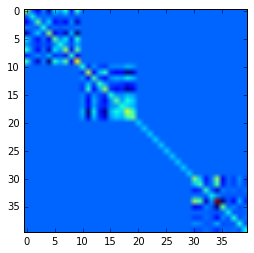

(100L, 40L)
size vs non-zero:  1600  vs  310


In [85]:
## skleanr spd data generation
from sklearn.datasets import make_spd_matrix as spd
def addOneGroup(one_group):
#     print "len:",len(one_group)
    return spd(len(one_group))
def stick(group,groupMatrix,X):
#     print type(group)
#     print type(groupMatrix)
#     print X.shape
#     print [group[i] for i in xrange(groupMatrix.shape[1])]
    for i in xrange(groupMatrix.shape[0]):
        for j in xrange(groupMatrix.shape[1]):
            X[group[i],group[j]] = groupMatrix[i,j]
def createToyData_spd(ranNum=20,size=(100,20),
                 groups=[np.array([0,1,2,3,4,5]),np.array([0,1,2]),np.array([3,4,5]),np.array([6,7,8,9])]):
    prng = np.random.RandomState(ranNum)
    n_samples,n_features=size[0],size[1]
    #prec = spd(n_dim = size[1], random_state = prng)
    prec = np.zeros((n_features,n_features))
    for g in groups:
        onegroup=addOneGroup(g)
        stick(g,onegroup,prec)
    for i in range(n_features):
        prec[i,i] += 1.
    cov = linalg.inv(prec)
    X = prng.multivariate_normal(np.zeros(size[1]), cov, size=size[0])
    X -= X.mean(axis=0)
    X /= X.std(axis=0)
    return X,prec
# groups=[np.array([0,1,2,3,4,5]),np.array([0,1,2]),np.array([3,4,5]),np.array([6,7,8,9]),np.array([6,7]),np.array([8,9]),
#        np.array([10,11,12,13,14,15]),np.array([10,11,12]),np.array([13,14,15]),np.array([16,17,18,19]),np.array([16,17]),
#         np.array([18,19]),np.array([6,7,8,9,10,11,12,13,14,15])]
#groups1=[np.array([0,1,2,3,4,5,6,7,8,9]),np.array([10,11,12,13,14,15,16,17,18,19])]
# groups2=[np.array([0,1,2,3,4,15,16,17,18,19]),np.array([10,11,12,13,14,5,6,7,8,9])]
# groups3=[np.array([0,1,19]),np.array([3,4,17]),np.array([10,2,18]),np.array([11,7,8,9]), np.array([12,13,6]) ,np.array([5,14,15,16])]
# X,prec=createToyData_spd(size=(100,20),groups=groups2)
## number of feature = 40
groups_40=[np.array(range(0,10)),np.array(range(10,20)),np.array(range(30,40))]
X,prec=createToyData_spd(size=(100,40),groups=groups_40)
plt.imshow(prec)
plt.show()
print X.shape
print "size vs non-zero: ", prec.size, " vs " ,np.count_nonzero(prec)

In [86]:
pennal_list=np.arange(0.01,0.5,0.08)
print pennal_list
print len(pennal_list)

[ 0.01  0.09  0.17  0.25  0.33  0.41  0.49]
7


In [87]:
ggl_list=[]
gl_list=[]
randy_list=[]
for pennal in pennal_list:
    print "iteration:", len(ggl_list)+1
    ###grouped graphic lasso
    S=np.cov(X.T)
    #print S.shape
    test=GroupGraphicLasso_1(S,pennal,groups_40)
    ggl_list.append(test)
    print "group lasso done" 
    ###graphic lasso
    model = GL(alpha=pennal)
    model.fit(X)
    prec_ = model.precision_
    
    print "lasso done"
    #cov_ = model.covariance_
    gl_list.append(prec_)
    print "randy done"
    ##randy
    randy_list.append(estimatePhi(S, pennal))
print "done"

iteration: 1
group lasso done
lasso done
randy done
iteration: 2
group lasso done
lasso done
randy done
iteration: 3
group lasso done
lasso done
randy done
iteration: 4
group lasso done
lasso done
randy done
iteration: 5
group lasso done
lasso done
randy done
iteration: 6
group lasso done
lasso done
randy done
iteration: 7
group lasso done
lasso done
randy done
done


In [88]:
#print len(ggl_list)
ggl_list = [set_zero(abs(i)) for i in ggl_list]
gl_list = [set_zero(abs(i)) for i in gl_list]
randy_list = [set_zero(abs(i)) for i in randy_list]
print "non_zero number of group graphical lasso:",[np.count_nonzero(i) for i in ggl_list]
print "non_zero number of graphical lasso:",[np.count_nonzero(i) for i in gl_list]
print "non_zero number of randy graphical lasso:",[np.count_nonzero(i) for i in randy_list]

non_zero number of group graphical lasso: [1432, 832, 532, 414, 326, 302, 284]
non_zero number of graphical lasso: [1390, 572, 180, 56, 14, 2, 0]
non_zero number of randy graphical lasso: [1390, 580, 192, 58, 15, 2, 0]


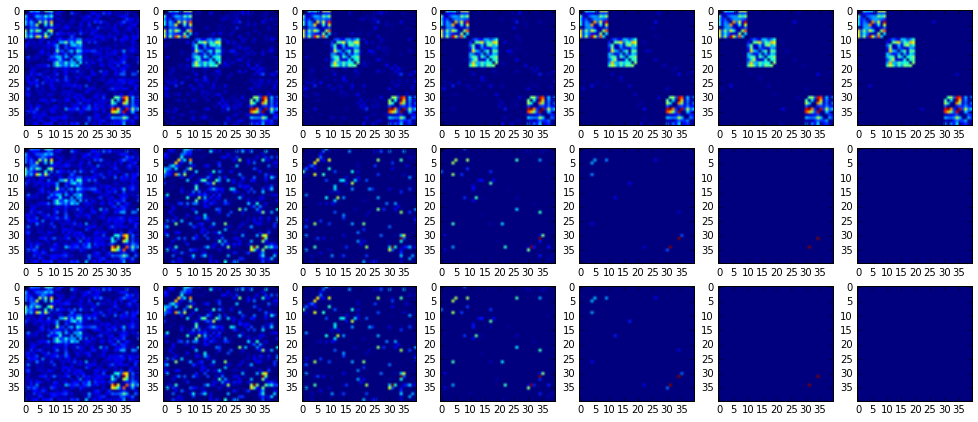

In [89]:
pennelty_number=len(ggl_list)
fig,ax = plt.subplots(ncols=pennelty_number,nrows=3)
for i in range(3):
    for j in range(pennelty_number):
            if i==0:
                value=ggl_list[j]
                ax[i][j].imshow(value)
            elif i==1:
                value=gl_list[j]
                ax[i][j].imshow(value)
            else:
                value=randy_list[j]
                ax[i][j].imshow(value)
fig.set_size_inches(17,7)
plt.show()

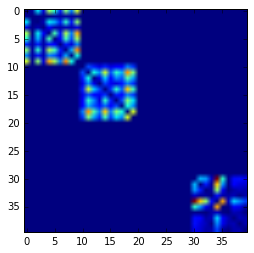

In [90]:
plt.imshow(set_zero(abs(prec)))
plt.show()

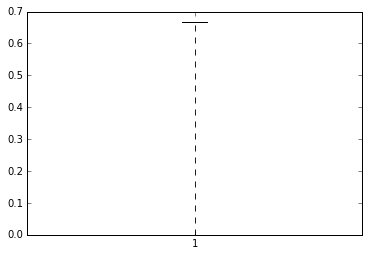

In [91]:
plt.boxplot(ggl_list[6].flatten())
plt.show()

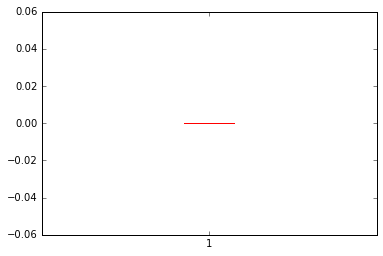

In [92]:
plt.boxplot(randy_list[6].flatten())
plt.show()

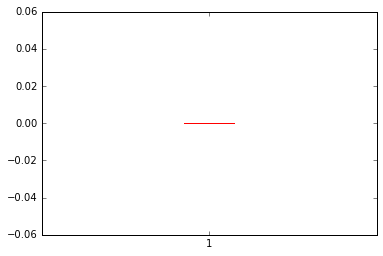

In [93]:
plt.boxplot(gl_list[6].flatten())
plt.show()

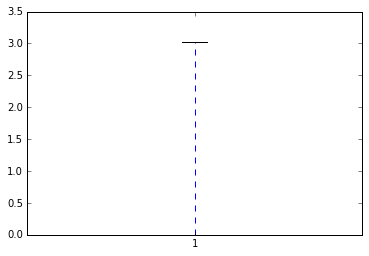

In [94]:
plt.boxplot(set_zero(abs(prec)).flatten())
plt.show()

In [1]:
def CountZero(A):
    count = 0
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if A[i,j] == 0:
                count += 1
    
    return count

In [2]:
from tabulate import tabulate

In [ ]:
table = [["Ground Truth",CountZero(A)],["Precision Matrix",CountZero(B)],
         ]
print tabulate(table)